<a href="https://colab.research.google.com/github/Camerajonas/ES96-Model/blob/master/ES96A_ML_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ES96A-ML
#### This is the collaborative notebook for building our machine learning process. When making edits, please comment amply.

## This section works through an example of Principle Component Regression and Ridge Regression.
LINK: https://nirpyresearch.com/pcr-vs-ridge-regression-nir-data-python/

In [0]:
# Load Dependencies
from google.colab import files 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

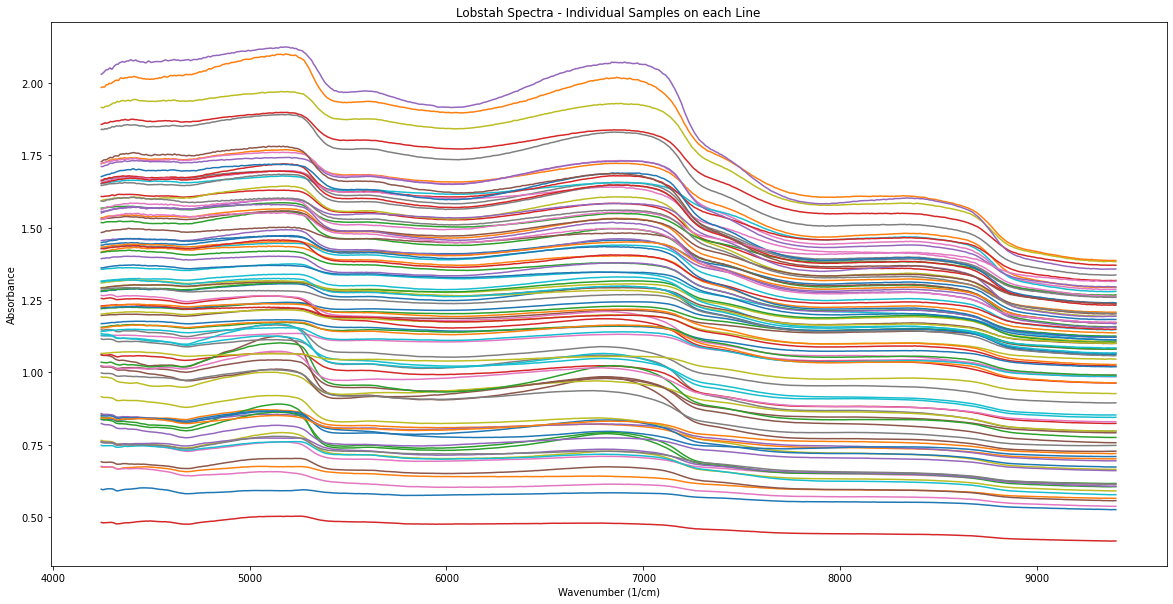

In [0]:
# Read in Spectra File from Github URL
url = 'https://raw.githubusercontent.com/Camerajonas/ES96-Model/master/LobsterRawData.csv'
spectra_raw = pd.read_csv(url) #read in csv file
array = spectra_raw.to_numpy() # convert pandas data frame to numpy array

wavenumber = array[:,0] # extract wavelength column
spectra = array[:,1:] # extract spectral columns

# Plot raw spectra
plt.figure(figsize=(20,10))
plt.plot(wavenumber, spectra)
plt.xlabel('Wavenumber (1/cm)')
plt.ylabel('Absorbance')
plt.title("Lobstah Spectra - Individual Samples on each Line")
plt.show()

# The plot below is the spectral data for some lobster thing.

In [0]:
# Define Reference Criteria (dry matter something in a lobster)
url = 'https://raw.githubusercontent.com/Camerajonas/ES96-Model/master/DryMatter.csv'
dry_matter = pd.read_csv(url) # read in dry matter reference values
y = dry_matter.to_numpy()[:,1] # convert to numpy array
X = spectra[:496].T # only the first 496 wavelengths are needed

In [0]:
# Principle Component Analysis
# This function is straight from the website with the sample code
# There is more information on PCR implementation at the link below
# https://nirpyresearch.com/principal-component-regression-python/

def pcr(X,y, pc, deriv=0, smooth=11):
    
    ''' Step 1: PCA on input data'''
    # Define the PCA object
    pca = PCA()
    
    # Preprocessing: derivative
    # These lines will filter and smooth out noise in the data
    if deriv == 1:
        X = savgol_filter(X, smooth, polyorder = 2, deriv=1)
    if deriv > 1:    
        X = savgol_filter(X, smooth, polyorder = 2, deriv=2)

    # Preprocess (2) Standardize features by removing the mean and scaling to unit variance
    # This process subtracts off the mean and divides by the standard deviation
    # to produce columns with mean 0 and unit variance. This is important because
    # PCR creates 'principle components' along the dimensions of greatest variance
    # in the data. If there are differing units, the variances could be arbitrarily
    # large and will influence the performance of the regression.
    Xstd = StandardScaler().fit_transform(X[:,:])

    # Run PCA producing the reduced variable Xreg and select the first pc components
    # This line runs the PCA transformation which takes all of the existing features
    # and rewrites them in terms of the principle components.
    Xreg = pca.fit_transform(Xstd)[:,:pc]
    ''' Step 2: regression on selected principal components'''

    # Create linear regression object
    # These lines run a linear regression model on the reduced data
    regr = linear_model.LinearRegression()
    # Fit
    regr.fit(Xreg, y)

    # Calibration
    y_c = regr.predict(Xreg)
    # Cross-validation
    y_cv = cross_val_predict(regr, Xreg, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    return(y_cv, score_c, score_cv, mse_c, mse_cv)

In [0]:
# call PCR function
predicted, r2r, r2cv, mser, mscv = pcr(X,y, pc=15) # onlt the first pc components are used

# I played around with the number of principle components kept in the model and
# the regression is highly sensitive to changes in the number of components used.

R2 calib: 0.794
R2 CV: 0.663
MSE calib: 1.602
MSE CV: 2.624


**R2 calib:** This is the correlation coefficient for the model on all input data <br>
**R2 calib:** the correlation coefficient for cross validated training data <br>
-> This means the input data is split into chunks and the model is trained on all but one of the chunks. The remaining chunk that was not used to train the model is then used to estimate the r^2 value. This process is repeated for all the chunks so that each chunk of the training data is compared to a model created by the rest of the training data. This is generally a better predictor of how the model will perfrom on new data. <br>
**MSE calib:** the mean squared error on all the data <br>
**MSE CV:** the mean squared error on the cross validated data <br>
-> MSE is a measure of goodness of fit. Lower Mean Squared Errors typically mean the model is fitted better but large differences in MSE on the training set and MSE for the cross validated set can mean the model is overfitting the data and will not perform well on novel measurements.

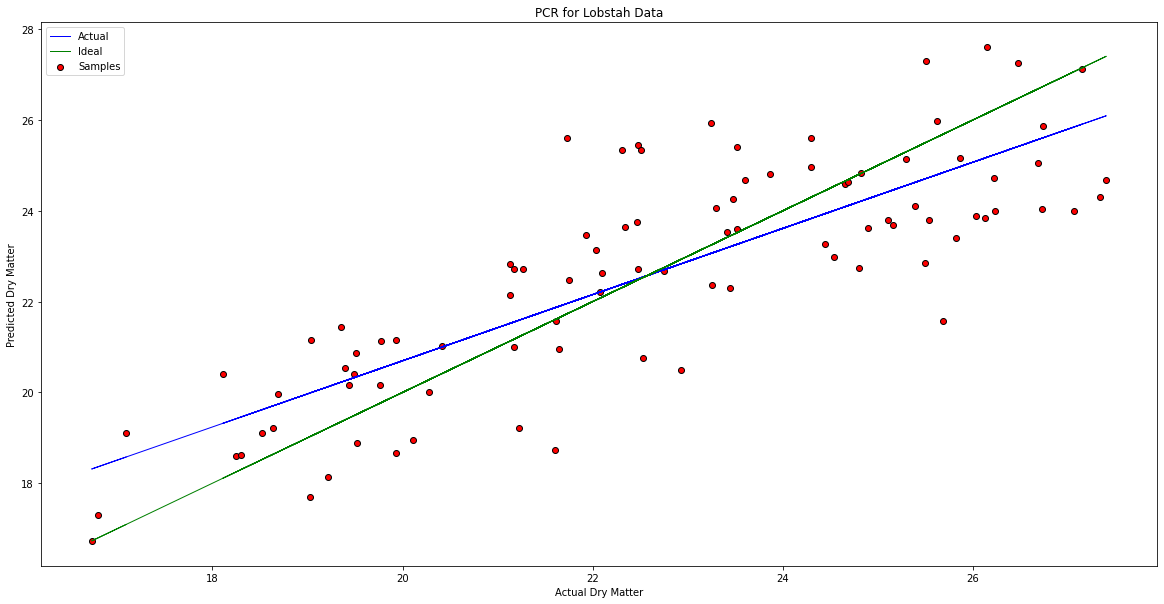

In [0]:
# Plot the PCR Results 

z = np.polyfit(y, predicted, 1) # Calculate best fit line

plt.figure(figsize=(20,10))
plt.scatter(y, predicted, c='red', edgecolors='k') # plot points
plt.plot(y, z[1]+z[0]*y, c='blue', linewidth=1) # plot regression line
plt.plot(y, y, color='green', linewidth=1) # plot ideal line
plt.xlabel("Actual Dry Matter")
plt.ylabel("Predicted Dry Matter")
plt.title("PCR for Lobstah Data")
plt.legend(["Actual", "Ideal","Samples"])
plt.show()

Notice in the above plot how the observed dry matter content is fairly close to the predicted dry matter contents. This model works well and has a correlation coefiicient (r^2) of about 0.79.